In [1]:
import numpy as np
import torch
from torch import nn
from math import floor

import matplotlib.pyplot as plt

In [149]:
from typing import Optional, Union
import math

class AbsMarkovChain(nn.Module):
    def __init__(
        self,
        n_classes: int,
        n_waypoints: int = 50,
        n_neighbors: int = 5,
    ) -> None:
        super().__init__()
        self.n_classes = n_classes
        self.n_waypoints = n_waypoints
        self.n_neighbors = n_neighbors

        initial_wps = torch.zeros(
            self.n_waypoints, 2, dtype=torch.float
        )
        nn.init.xavier_normal_(initial_wps)

        self.waypoints = nn.Parameter(initial_wps)
        self.origin = nn.Parameter(
            torch.zeros(
                1, 2, dtype=torch.float
            ), requires_grad=False)

        self.trans_states, self.abs_states = self._get_states()

    def _get_states(self):
        sorted_states = torch.argsort(
            torch.sqrt(torch.sum(torch.square(self.waypoints), dim=1))
        )

        abs_states = sorted_states[-self.n_classes:]
        trans_states = sorted_states[:-self.n_classes]
        return trans_states, abs_states

    @staticmethod
    def _gaussian_neighborhood(adj: torch.Tensor) -> torch.Tensor:
        sigma = torch.sqrt(
            torch.mean(torch.square(adj), dim=1)
        ).unsqueeze(1)

        x = torch.div(torch.square(adj), 2 * torch.square(sigma))
        return torch.exp(torch.neg(x))

    def _construct_markov_chain(self) -> torch.Tensor:
        # calculate pseudotime of waypoints
        pseudotime = torch.cdist(self.waypoints, self.origin)
        pseudotime = (pseudotime - pseudotime.min()) / (pseudotime.max() - pseudotime.min())

        # calculate pseudotime differences and distances
        pt_diff = pseudotime.view(1, -1) - pseudotime
        adj = torch.cdist(self.waypoints, self.waypoints)

        # distances to probabilies with gaussian neighborhood
        adj = self._gaussian_neighborhood(adj)

        # reduce probability of backward edges with the derivative of ELU
        adj[pt_diff < 0] = adj[pt_diff < 0] * torch.exp(10 * pt_diff[pt_diff < 0])

        # delete self-assigning edges
        T = adj - torch.eye(adj.size(0), adj.size(1))

        # rescale so that row probabilities sum up to 1
        T = T / T.sum(dim=1).unsqueeze(1)
        # transform transition matrix to absorbing transition matrix
        T[self.abs_states, :] = 0
        T[self.abs_states, self.abs_states] = 1
        return T

    def _absorption_prob(self, T: torch.Tensor) -> torch.Tensor:
        # get Q and fundamental matrix
        Q = T[self.trans_states, :][:, self.trans_states]
        mat = torch.eye(Q.shape[0]) - Q
        N = torch.linalg.inv(mat)

        # absorption probabilities
        abs_prob = torch.matmul(N, T[self.trans_states, :][:, self.abs_states])  # N @ R
        abs_prob[abs_prob < 0] = 0
        return abs_prob

    def _weight_matrix(self, x: torch.Tensor) -> torch.Tensor:
        w = torch.cdist(x, self.waypoints)
        w = self._gaussian_neighborhood(w)
        w = w / w.sum(dim=1).unsqueeze(1)
        return w

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # transition matrix
        T = self._construct_markov_chain()  # [W, W]
        # branch probabilities
        branch_probs = torch.zeros(self.n_waypoints, self.n_classes, device=x.device)  # [W, n_classes]
        branch_probs[self.trans_states, :] = self._absorption_prob(T)
        branch_probs[self.abs_states, torch.arange(self.n_classes)] = 1
        # weight matrix for x
        w = self._weight_matrix(x)  # [B, W]

        pred = torch.matmul(w, branch_probs)  # [B, n_classes]
        return pred



tensor(12818.3086)

In [167]:
model = AbsMarkovChain(n_waypoints=100, n_classes=5)


In [168]:
wps = model.waypoints.detach().numpy()
abs_states = model.abs_states.numpy()
T = model._construct_markov_chain()
branch_prob = model._absorption_prob(T)


In [169]:
select = model.waypoints[0, :].detach().unsqueeze(0)
pred = model.forward(select)
sel = select.numpy()

In [170]:
pred = pred.detach().numpy()
t = T.detach().numpy()

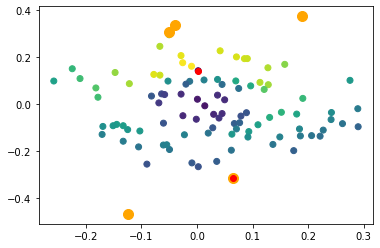

In [171]:
plt.scatter(wps[:, 0], wps[:, 1], c=t[0, :])
plt.scatter(sel[:, 0], sel[:, 1], color="r")
plt.scatter(wps[abs_states, 0], wps[abs_states, 1], s=100, color="orange")

max_ix = abs_states[np.argmax(pred[0, :])]
plt.scatter(wps[max_ix, 0], wps[max_ix, 1], color="r")



In [93]:
class MarkovCluster(nn.Module):
    def __init__(
        self,
        n_classes: int,
        n_waypoints: int = 50,
        n_neighbors: int = 5
    ) -> None:
        super().__init__()
        self.n_classes = n_classes
        self.n_waypoints = n_waypoints
        self.n_neighbors = n_neighbors

        initial_wps = torch.zeros(
            self.n_waypoints, 2, dtype=torch.float
        )
        nn.init.xavier_uniform_(initial_wps)

        self.wps = nn.Parameter(initial_wps)
        self._trans_states = None
        self._abs_states = None
        self.origin = nn.Parameter(
            torch.zeros(
                1, 2, dtype=torch.float
            ), requires_grad=False)

    @staticmethod
    def _stationary_distribution(T):
        """
        Get stationary distribution by eigen decomposition.
        """
        evals, evecs = torch.linalg.eig(T.T)

        near_one_ix = torch.argsort(torch.abs(torch.sub(evals, 1)))

        stationary = evecs[:, near_one_ix]
        stationary = stationary[:, 0]  # closest to one
        stationary = stationary / stationary.sum()
        return stationary.real

    def _construct_markov_chain(self):
        # calculate pseudotime of waypoints
        pseudotime = torch.cdist(self.wps, self.origin)
        pseudotime = (pseudotime - pseudotime.min()) / (pseudotime.max() - pseudotime.min())

        # calculate pseudotime differences and distances
        pt_diff = pseudotime.reshape(1, -1) - pseudotime
        adj = torch.cdist(self.wps, self.wps)

        # get adjacency and distance matrix
        dist, sort_idxs = torch.sort(adj, dim=1)
        y_idxs = torch.arange(
            dist.shape[0]).unsqueeze(1).repeat(
            (1, dist.shape[1]))
        adj_idx = sort_idxs[:, self.n_neighbors:]
        adj[y_idxs[:, self.n_neighbors:].flatten(), adj_idx.flatten()] = 0

        # standard deviation allowing for "back" edges
        adpative_k = min([int(floor(self.n_neighbors / 3)) - 1, 30])
        adaptive_std = dist[:, adpative_k]

        # remove egdes that point backward in time (except std)
        adj[pt_diff < -adaptive_std.unsqueeze(1)] = 0

        # affinity and transition matrix
        adaptive_std_y = adaptive_std.unsqueeze(1).tile((1, adj.shape[1]))
        adaptive_std_x = adaptive_std.unsqueeze(0).tile((adj.shape[0], 1))
        nonzero_mask = adj > 0
        T = torch.zeros_like(adj)
        T[nonzero_mask] = torch.exp(
            -(adj[nonzero_mask] ** 2) / (adaptive_std_y[nonzero_mask] ** 2) * 0.5
            - (adj[nonzero_mask] ** 2) / (adaptive_std_x[nonzero_mask] ** 2) * 0.5
        )

        T = T / T.sum(dim=1).unsqueeze(1)
        T = torch.nan_to_num(T)
        return T

    def _absorption_prob(self, T, stationary):
        # infer absorbing and transition states
        sort_stationary_idxs = torch.argsort(stationary)
        abs_states = sort_stationary_idxs[-self.n_classes:]
        trans_states = sort_stationary_idxs[:-self.n_classes]
        self._trans_states = self.wps[trans_states]
        self._abs_states = self.wps[abs_states]

        # update transition matrix that it becomes a absorbing transition matrix
        T[abs_states, :] = 0
        T[abs_states, abs_states] = 1

        # get Q and fundamental matrix
        Q = T[trans_states, :][:, trans_states]
        mat = torch.eye(Q.shape[0]) - Q
        N = torch.linalg.inv_ex(mat, check_errors=False).inverse

        # absorption probabilities
        abs_prob = torch.matmul(N, T[trans_states, :][:, abs_states])
        abs_prob[abs_prob < 0] = 0
        return abs_prob

    def forward(self, x: torch.Tensor):
        # get current markov chain
        T = self._construct_markov_chain()
        # get stationary distribution
        stationary = self._stationary_distribution(T)
        # absorption probability
        abs_prob = self._absorption_prob(T, stationary)

        return abs_prob

In [98]:
mc = MarkovCluster(n_classes=4,
                   n_waypoints=50,
                   n_neighbors=10)


In [99]:
t = torch.randn(4, 2)
out = mc(t)
print(out)

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0333e-02, 7.2024e-03, 5.7552e-01, 3.8506e-01],
        [1.1401e-04, 6.8585e-03, 6.6449e-03, 4.6098e-03],
        [8.1544e-09, 4.1576e-02, 9.4528e-01, 1.3136e-02],
        [3.9573e-05, 4.8677e-04, 2.3065e-03, 1.6001e-03],
        [9.4444e-06, 1.3653e-03, 5.5046e-04, 3.8187e-04],
        [0.0000e+00, 2.5115e-04, 9.0039e-02, 9.0971e-01],
        [0.0000e+00, 1.6816e-02, 9.6921e-01, 1.3968e-02],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.4975e-12, 1.0000e+00, 8.7279e-11, 6.0549e-11],
        [0.0000e+00, 4.3250e-03, 0.0000e+00, 0.0000e+00],
        [1.9809e-02, 1.1760e-02, 6.3952e-01, 3.1774e-01],
        [0.0000e+00, 4.3250e-03, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 2.5700e-02, 9.2113e-01, 5.3168e-02],
        [9.2152e-03, 6.5567e-03, 5.5207e-01, 3.9094e-01],
        [5.3782e-05, 3.0065e-05, 3.1346e-03, 2.1746e-03],
        [9.227

In [100]:
out.shape

torch.Size([46, 4])

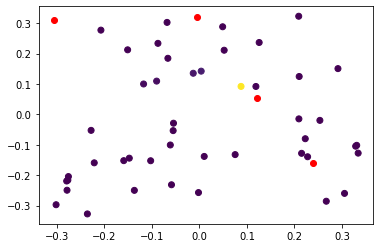

In [101]:
import matplotlib.pyplot as plt

trans_states = mc._trans_states.detach().numpy()
abs_states = mc._abs_states.detach().numpy()
out = out.detach().numpy()
plt.scatter(trans_states[:, 0], trans_states[:, 1], c=out[:, 0])
plt.scatter(abs_states[:, 0], abs_states[:, 1], color="r")

In [83]:
from typing import Optional

import torch
import torch.nn as nn

class SOMC(nn.Module):
    """
    Self-organizing Markov Chain.
    """
    def __init__(
            self,
            n_waypoints: int = 100,
            alpha: float = 0.3,
            max_epochs: Optional[float] = None,
            sigma: Optional[float] = None):
        super().__init__()

        self.max_epochs = max_epochs
        self.alpha = alpha

        if sigma is None:
            sigma = torch.Tensor([n_waypoints / 20])
        self.sigma = sigma

        self.waypoints = torch.randn(n_waypoints, 2).double()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Find the location of best matching unit.

        """
        dists = torch.cdist(x, self.waypoints)  # [B, M]

        bmu_idxs = dists.argmin(dim=1)
        bmus = self.waypoints[bmu_idxs, :]  # [B, 2]

        return bmus

    def neighborhood_fn(self, bmus: torch.Tensor, sigma: float):
        """
        Gaussian neighborhood function
            .. math:: e^(-(d(r_c, r_i)^2 / 2 * sigma^2))
        """
        squared_dist = torch.square(
            torch.cdist(bmus, self.waypoints)  # [B, M]
        )
        x = torch.div(squared_dist, sigma ** 2)
        return torch.exp(torch.neg(x))

    def backward(
            self,
            x: torch.Tensor,
            bmus: torch.Tensor,
            epoch: Optional[int] = None
    ) -> None:
        """
        Update the weights of the neighborhood
        """
        # set learning rate
        iter_correction = 1.0
        if self.max_epochs is not None and epoch is not None:
            iter_correction = 1.0 - epoch / self.max_epochs
        alpha = self.alpha * iter_correction

        neighborhood = self.neighborhood_fn(bmus, self.sigma)
        neighborhood = torch.mul(neighborhood, alpha)

        elementwise_diffs = x.unsqueeze(1) - self.waypoints.unsqueeze(0)  # [B, M, 2]
        delta = neighborhood.unsqueeze(2) * elementwise_diffs  # [B, M, 2]
        # take the mean over the batch
        delta = torch.mean(delta, dim=0)  # [M, 2]
        # update weights
        self.waypoints = torch.add(self.waypoints, delta)
        return None


In [77]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

iris = datasets.load_iris()
data = iris.data[:, :2]

scaler = StandardScaler()
data = scaler.fit_transform(data)
data = torch.from_numpy(data).double()


In [14]:
def train_som(som: nn.Module,
              data: torch.Tensor,
              epochs: int = 10,
              batch_size: int = 32):
  """
  Basic training loop for our Som.
  """
  n_batches = data.shape[0] // batch_size
  for epoch in range(epochs):
    # print(f'Epoch {epoch+1}/{epochs}')
    for i in range(n_batches):
      batch_start = i * batch_size
      batch_end = (i + 1) * batch_size
      x = data[batch_start:batch_end]
      bmus = som.forward(x)
      som.backward(x, bmus, epoch=epoch)

In [86]:
som = SOMC(max_epochs=None, alpha=0.1, sigma=2)

In [28]:
# train_som(som, data, epochs=1, batch_size=6)


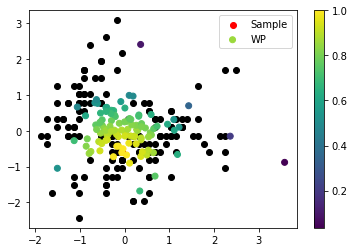

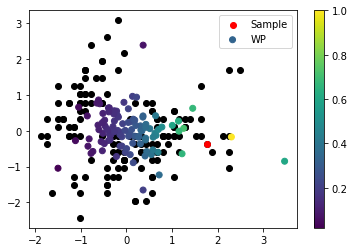

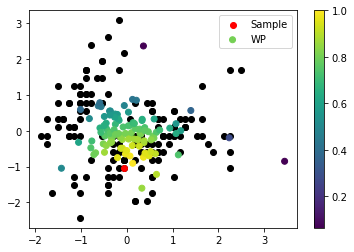

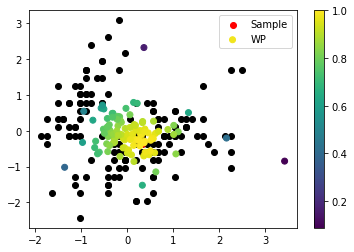

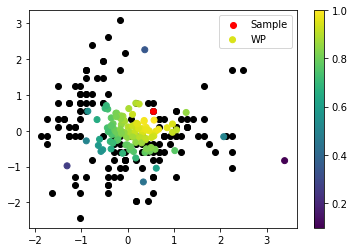

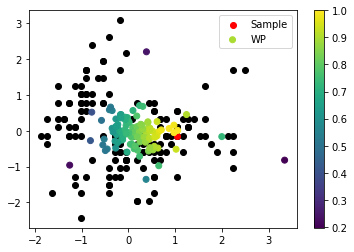

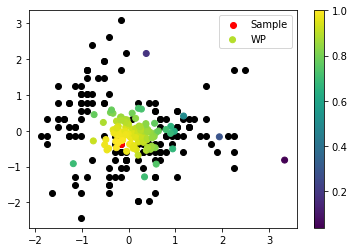

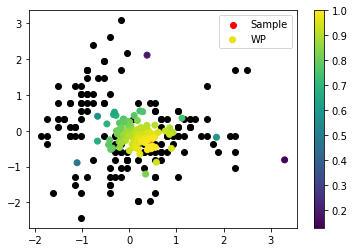

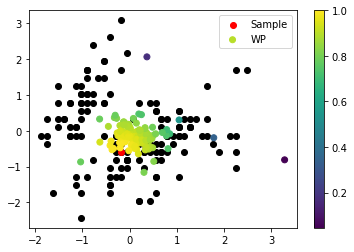

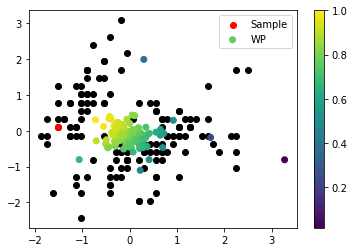

In [89]:
X = data.numpy()

for i in range(10):
    choice = np.random.randint(0, X.shape[0])
    x = data[choice, :].unsqueeze(0)
    wps_before = som.waypoints.detach().numpy()
    bmus = som.forward(x)
    neighborhood = som.neighborhood_fn(bmus, som.sigma).numpy()
    som.backward(x, bmus)
    wps_after = som.waypoints.detach().numpy()

    plt.figure()

    plt.scatter(X[:, 0], X[:, 1], color="black")
    plt.scatter(x[0, 0], x[0, 1], color="r", label="Sample")
    plt.scatter(wps_after[:, 0], wps_after[:, 1], c=neighborhood.flatten(), label="WP")

    plt.legend()
    plt.colorbar()


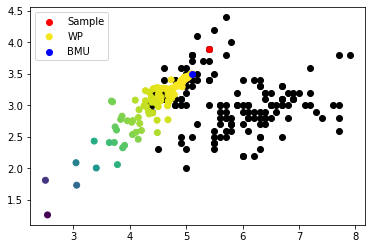

In [62]:
plt.scatter(X[:, 0], X[:, 1], color="black")
plt.scatter(x[0, 0], x[0, 1], color="r", label="Sample")
plt.scatter(wps_before[:, 0], wps_before[:, 1], c=neighborhood.flatten(), label="WP")
plt.scatter(bmus[0, 0], bmus[0, 1], color="blue", label="BMU")

plt.legend()

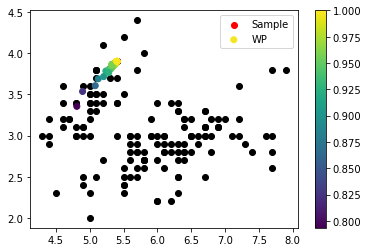

In [63]:
plt.scatter(X[:, 0], X[:, 1], color="black")
plt.scatter(x[0, 0], x[0, 1], color="r", label="Sample")
plt.scatter(wps_after[:, 0], wps_after[:, 1], c=neighborhood.flatten(), label="WP")

plt.legend()
plt.colorbar()


In [157]:
x = torch.randn(32, 2).double()

In [122]:
bmus = som.forward(x)

In [123]:
som.waypoints

tensor([[ 5.7832e-01, -5.8985e-01],
        [-2.4410e-01, -5.6630e-02],
        [-3.7787e-01,  5.7878e-01],
        [-1.3632e-01, -5.9683e-01],
        [-2.2295e-01, -9.4519e-02],
        [-6.3305e-01, -8.4994e-02],
        [ 9.2553e-03,  1.5123e-01],
        [ 2.4656e-01,  6.5265e-02],
        [-2.3253e-01, -7.4025e-02],
        [-1.9657e-01,  1.1253e-01],
        [ 2.0037e-01, -1.8214e-01],
        [-2.4442e-01, -8.2058e-01],
        [-4.6205e-01,  4.1501e-01],
        [-4.2770e-01,  4.7168e-01],
        [ 3.1296e-01, -2.3923e-01],
        [ 9.0368e-02, -1.0554e+00],
        [ 3.4258e-01, -4.6865e-01],
        [-5.0464e-02, -4.9945e-01],
        [-2.5432e-02, -5.9022e-02],
        [-1.0750e-01,  5.6892e-01],
        [-4.2260e-01, -1.6119e-01],
        [ 2.7397e-01, -3.1818e-01],
        [-3.1168e-02, -5.0310e-01],
        [ 1.9436e-01, -4.6957e-02],
        [ 3.2348e-01, -1.8703e-01],
        [-4.1981e-01, -1.0867e-01],
        [ 6.5733e-01,  4.7930e-01],
        [-3.4575e-01, -2.464

In [124]:
som.backward(x, bmus)

tensor([ 0.5783, -0.5898], dtype=torch.float64)
tensor([-0.1869,  0.1751], dtype=torch.float64)
<class 'torch.Tensor'> <class 'torch.Tensor'>
tensor([ 0.3914, -0.4148], dtype=torch.float64)


In [125]:
som.waypoints

tensor([[ 0.3914, -0.4148],
        [-0.1944, -0.0330],
        [-0.2900,  0.4203],
        [-0.1181, -0.4182],
        [-0.1794, -0.0599],
        [-0.4716, -0.0530],
        [-0.0146,  0.1146],
        [ 0.1539,  0.0533],
        [-0.1862, -0.0453],
        [-0.1606,  0.0873],
        [ 0.1211, -0.1225],
        [-0.1953, -0.5792],
        [-0.3498,  0.3033],
        [-0.3254,  0.3437],
        [ 0.2011, -0.1633],
        [ 0.0438, -0.7496],
        [ 0.2226, -0.3271],
        [-0.0570, -0.3485],
        [-0.0392, -0.0348],
        [-0.0974,  0.4126],
        [-0.3214, -0.1073],
        [ 0.1735, -0.2195],
        [-0.0433, -0.3511],
        [ 0.1168, -0.0264],
        [ 0.2086, -0.1262],
        [-0.3194, -0.0699],
        [ 0.4480,  0.3489],
        [-0.2667, -0.1680],
        [-0.3654,  0.0648],
        [-0.2482,  0.3021],
        [ 0.0119,  0.0186],
        [ 0.0645, -0.2526],
        [ 0.1237, -0.1880],
        [-0.2747, -0.0748],
        [ 0.0235,  0.2057],
        [ 0.0374, -0

In [288]:
t = torch.randn(10, 2)
w = torch.randn(5, 2)

In [295]:
class SOM(nn.Module):
    def __init__(self, input_size=2, out_size=(10, 10), lr=0.3, sigma=None):
        '''
        :param input_size:
        :param out_size:
        :param lr:
        :param sigma:
        '''
        super(SOM, self).__init__()
        self.input_size = input_size
        self.out_size = out_size

        self.lr = lr
        if sigma is None:
            self.sigma = max(out_size) / 2
        else:
            self.sigma = float(sigma)

        self.weight = nn.Parameter(torch.randn(input_size, out_size[0] * out_size[1]), requires_grad=False)
        self.locations = nn.Parameter(torch.Tensor(list(self.get_map_index())), requires_grad=False)
        self.pdist_fn = nn.PairwiseDistance(p=2)

    def get_map_index(self):
        '''Two-dimensional mapping function'''
        for x in range(self.out_size[0]):
            for y in range(self.out_size[1]):
                yield (x, y)

    def _neighborhood_fn(self, input, current_sigma):
        '''e^(-(input / sigma^2))'''
        input.div_(current_sigma ** 2)
        input.neg_()
        input.exp_()

        return input

    def forward(self, input):
        '''
        Find the location of best matching unit.
        :param input: data
        :return: location of best matching unit, loss
        '''
        batch_size = input.size()[0]
        input = input.view(batch_size, -1, 1)
        batch_weight = self.weight.expand(batch_size, -1, -1)

        dists = self.pdist_fn(input, batch_weight)
        # Find best matching unit
        losses, bmu_indexes = dists.min(dim=1, keepdim=True)
        bmu_locations = self.locations[bmu_indexes]

        return bmu_locations, losses.sum().div_(batch_size).item()

    def self_organizing(self, input, current_iter, max_iter):
        '''
        Train the Self Oranizing Map(SOM)
        :param input: training data
        :param current_iter: current epoch of total epoch
        :param max_iter: total epoch
        :return: loss (minimum distance)
        '''
        batch_size = input.size()[0]
        #Set learning rate
        iter_correction = 1.0 - current_iter / max_iter
        lr = self.lr * iter_correction
        sigma = self.sigma * iter_correction

        #Find best matching unit
        bmu_locations, loss = self.forward(input)

        distance_squares = self.locations.float() - bmu_locations.float()
        distance_squares.pow_(2)
        distance_squares = torch.sum(distance_squares, dim=2)

        lr_locations = self._neighborhood_fn(distance_squares, sigma)
        lr_locations.mul_(lr).unsqueeze_(1)

        delta = lr_locations * (input.unsqueeze(2) - self.weight)
        delta = delta.sum(dim=0)
        delta.div_(batch_size)
        self.weight.data.add_(delta)

        return loss

In [370]:
som = SOM(lr=0.03)

In [389]:
def train_som(som: nn.Module,
              data: torch.Tensor,
              epochs: int = 10,
              batch_size: int = 32):
  """
  Basic training loop for our Som.
  """
  losses = []

  n_batches = data.shape[0] // batch_size
  for epoch in range(epochs):
    # print(f'Epoch {epoch+1}/{epochs}')
    for i in range(n_batches):
      batch_start = i * batch_size
      batch_end = (i + 1) * batch_size
      x = data[batch_start:batch_end]
      loss = som.self_organizing(x, 1, epochs)
      losses.append(loss)

  return losses

In [390]:
loss = train_som(som, data, epochs=100, batch_size=6)

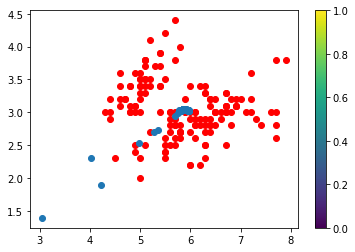

In [391]:
import matplotlib.pyplot as plt

wps = som.weight.detach().numpy()
X = data.numpy()

plt.scatter(X[:, 0], X[:, 1], color="r")
plt.scatter(wps[0], wps[1])
# plt.scatter(bmus[3, 0], bmus[3, 1], color="red")
plt.colorbar()


In [304]:
wps

array([[ 7.8884542e-01,  8.0301338e-01,  8.0885774e-01,  7.9896909e-01,
         7.4499667e-01,  6.5626389e-01,  4.2398071e-01,  5.1123913e-02,
        -4.4190726e-01,  2.9173031e-01,  7.8430712e-01,  7.9890037e-01,
         8.0388576e-01,  7.8946227e-01,  7.3426789e-01,  6.4192641e-01,
         3.7214324e-01, -5.1074415e-02,  5.3113419e-01,  1.8444993e+00,
         7.6605839e-01,  7.8406888e-01,  7.8339767e-01,  7.5588989e-01,
         6.8627244e-01,  5.6946212e-01,  4.5307197e-02, -7.6488607e-02,
         3.2777552e-02,  5.1250738e-01,  7.1347076e-01,  7.2814000e-01,
         7.2220010e-01,  6.9519770e-01,  6.2404901e-01,  3.3044493e-01,
         2.1182859e-01,  4.8973131e-01,  2.6492214e-01, -1.0578126e+00,
         6.3748264e-01,  6.2370479e-01,  6.1288685e-01,  5.7263178e-01,
         5.6610155e-01,  4.9496716e-01, -1.3506557e-01,  2.9754585e-01,
        -6.4676404e-01,  9.6366119e-01,  4.6496591e-01,  5.0552320e-01,
         4.9209329e-01,  4.2270336e-01,  1.8393694e-01,  1.00978